# 探索客人的评论分数及其与伦敦Airbnb房东/房源/街区的属性关系

In [1]:
from pathlib import Path

import requests
from tqdm import tqdm

import numpy as np
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import altair as alt

In [2]:
sns.set_style('white')

alt.themes.enable('default')
alt.renderers.enable('kaggle')
alt.renderers.set_embed_options(actions=False)
alt.data_transformers.enable('json')

DataTransformerRegistry.enable('json')

## 业务理解

### 确定业务目标

**背景**

Airbnb成立于2008年，已经成为全球旅行者非常喜爱的服务。

在过去的几年里，伦敦的Airbnb房源数量显著增长，尤其是在2015年合法化之后（https://www.travelgumbo.com/blog/london-legalizes-airbnb-similar-rentals）。

**业务目标**

- Airbnb 如何才能提高其在伦敦潜在用户心目中的声誉？

**业务成功标准**

- 给出有用的见解，Airbnb用户的整体印象取决于什么，可能如何改进它。

### 评估情况
**资源清单**
- 数据
    - Airbnb项目内部（http://insideairbnb.com/）
- 硬件
    - 谷歌云平台
- 软件
    - Python数据科学平台(Anaconda)
    
**要求、假设和制约因素**
- 访客评论分数可以成为评估房东/房源/街区 "吸引力 "的可靠因素。
- 较好的客人评价将带来服务声誉的提高，并带来更多的预订和用户。

### 确定数据挖掘目标
**数据挖掘目标**
- 根据客人的评价分数，租房时选择哪个小区比较好？
- 不同类型的客人评价分数之间有什么关系吗？
- 房东/房源属性与客人评价分数的关系如何？

**数据挖掘成功标准**
- 界定与客人评论分数类型关系密切的房东/房源/街区的特征

### 制订项目计划
**项目计划**
- 采集
   - 数据来源：伦敦的Airbnb数据来自Inside Airbnb项目
- 评估
   - 描述数据
   - 探索数据的有用特性
- 清洗
   - 选择所需的数据子集
   - 分类数据的预处理
   - 缺失数据的预处理
   - 根据选定的特征生成其他特征
- 分析
   - 分析数据以回答相关问题
- 可视化
   - 将结果可视化
- 结果
   - 制定业务/数据挖掘问题的答案。
 
**工具和技术的初步评估**
- 语言
   - python
- 包
   - 数据加载
       - requests, pandas, geopandas
   - 数据分析
       - numpy, pandas, geopandas
   - 可视化
       - matplotlib, seaborn, altair

## 了解数据

### 收集初始数据 

In [3]:
listings_df = pd.read_csv('./data/listings_summary.csv',
                          parse_dates=['last_review'])
listings_detail_df = pd.read_csv('./data/listings.csv', low_memory=False,
                                 parse_dates=['host_since', 
                                              'last_scraped', 'calendar_last_scraped',
                                              'first_review', 'last_review'])

reviews_df = pd.read_csv('./data/reviews_summary.csv', parse_dates=['date'])
reviews_detail_df = pd.read_csv('./data/reviews.csv', parse_dates=['date'])

calendar_df = pd.read_csv('./data/calendar.csv', parse_dates=['date'])

neighbourhoods_df = pd.read_csv('./data/neighbourhoods.csv')
gdf = gpd.read_file('./data/neighbourhoods.geojson')

### 描述数据 

**伦敦房源的汇总信息和指标**

In [11]:
listings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85068 entries, 0 to 85067
Data columns (total 16 columns):
id                                85068 non-null int64
name                              85043 non-null object
host_id                           85068 non-null int64
host_name                         85056 non-null object
neighbourhood_group               0 non-null float64
neighbourhood                     85068 non-null object
latitude                          85068 non-null float64
longitude                         85068 non-null float64
room_type                         85068 non-null object
price                             85068 non-null int64
minimum_nights                    85068 non-null int64
number_of_reviews                 85068 non-null int64
last_review                       65062 non-null datetime64[ns]
reviews_per_month                 65062 non-null float64
calculated_host_listings_count    85068 non-null int64
availability_365                  85068 non-null 

**伦敦的详细房源数据**

In [12]:
listings_detail_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85068 entries, 0 to 85067
Columns: 106 entries, id to reviews_per_month
dtypes: datetime64[ns](5), float64(23), int64(21), object(57)
memory usage: 68.8+ MB


In [13]:
print(listings_detail_df.columns.tolist())

['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary', 'space', 'description', 'experiences_offered', 'neighborhood_overview', 'notes', 'transit', 'access', 'interaction', 'house_rules', 'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since', 'host_location', 'host_about', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_listings_count', 'host_total_listings_count', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'street', 'neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market', 'smart_location', 'country_code', 'country', 'latitude', 'longitude', 'is_location_exact', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', 'square_feet', 'price', 'weekly_price', 'monthly_price', '

**伦敦房源的详细Calendar数据**

In [14]:
calendar_df.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31050094 entries, 0 to 31050093
Data columns (total 7 columns):
listing_id        31050094 non-null int64
date              31050094 non-null datetime64[ns]
available         31050094 non-null object
price             31049176 non-null object
adjusted_price    31049176 non-null object
minimum_nights    31050084 non-null float64
maximum_nights    31050084 non-null float64
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 1.6+ GB


**总的评论数据和房源ID**

In [15]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1486236 entries, 0 to 1486235
Data columns (total 2 columns):
listing_id    1486236 non-null int64
date          1486236 non-null datetime64[ns]
dtypes: datetime64[ns](1), int64(1)
memory usage: 22.7 MB


**伦敦房源的详细评论数据**

In [16]:
reviews_detail_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1486236 entries, 0 to 1486235
Data columns (total 6 columns):
listing_id       1486236 non-null int64
id               1486236 non-null int64
date             1486236 non-null datetime64[ns]
reviewer_id      1486236 non-null int64
reviewer_name    1486236 non-null object
comments         1485614 non-null object
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 68.0+ MB


**地理过滤器的街区列表**

In [17]:
neighbourhoods_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33 entries, 0 to 32
Data columns (total 2 columns):
neighbourhood_group    0 non-null float64
neighbourhood          33 non-null object
dtypes: float64(1), object(1)
memory usage: 608.0+ bytes


**城市街区的GeoJSON文件**

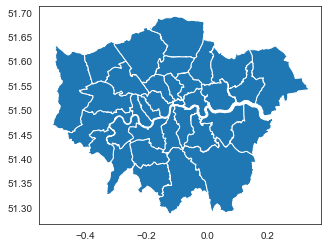

In [18]:
gdf.plot();

数据描述报告
- 上述数据汇总统计数字是需要过多解释的
- 更多的数据考虑因素可以在Inside Airbnb项目页面上找到。
http://insideairbnb.com/about.html

### 探索数据

**伦敦房源的汇总信息和指标**

数据样本

In [19]:
listings_df.head(1)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,11551,Arty and Bright London Apartment in Zone 2,43039,Adriano,NaN,Lambeth,51.46225,-0.11732,Entire home/apt,88,3,185,2019-09-15,1.58,2,336


存在缺失值的特征

In [20]:
print(listings_df.shape)
listings_df.loc[:, listings_df.isnull().sum() > 0].isnull().sum().sort_values(ascending=False)

(85068, 16)


neighbourhood_group    85068
reviews_per_month      20006
last_review            20006
name                      25
host_name                 12
dtype: int64

零方差的特征

In [21]:
listings_df.loc[:, listings_df.nunique() <= 1].nunique().sort_values()

neighbourhood_group    0
dtype: int64

日期特征的汇总信息

In [22]:
listings_df.describe(include='datetime')

,last_review
count,65062
unique,1818
top,2019-11-03 00:00:00
freq,1688
first,2011-07-02 00:00:00
last,2019-11-06 00:00:00


字符特征的汇总信息

In [23]:
listings_df.describe(include=['object'])

,name,host_name,neighbourhood,room_type
count,85043,85056,85068,85068
unique,82447,14573,33,4
top,Double room,Veeve,Westminster,Entire home/apt
freq,37,1235,9588,47445


按街区划分的房源数量

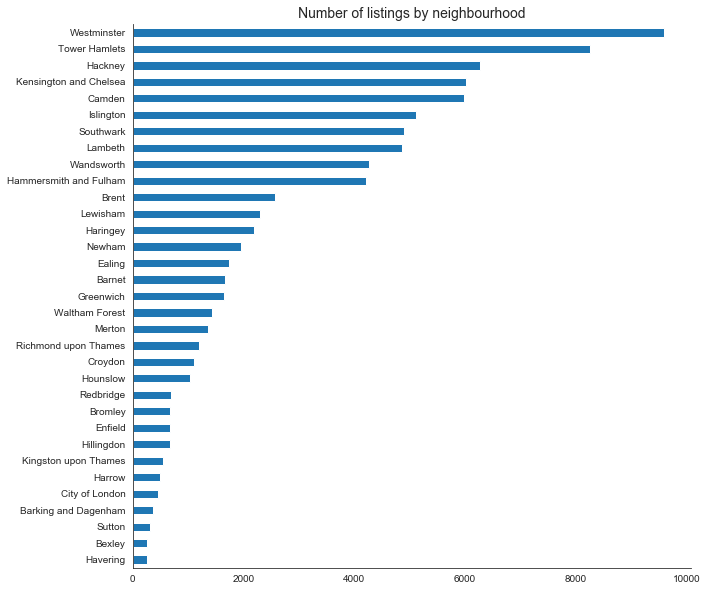

In [24]:
listings_df['neighbourhood'].value_counts().sort_values().plot.barh(figsize=(10, 10));
sns.despine()
plt.title('Number of listings by neighbourhood', fontsize=14);

不同房间型号的数量

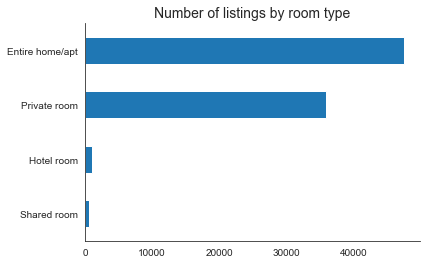

In [25]:
listings_df['room_type'].value_counts(dropna=False).sort_values().plot.barh()
sns.despine()
plt.title('Number of listings by room type', fontsize=14);

数值特征分布

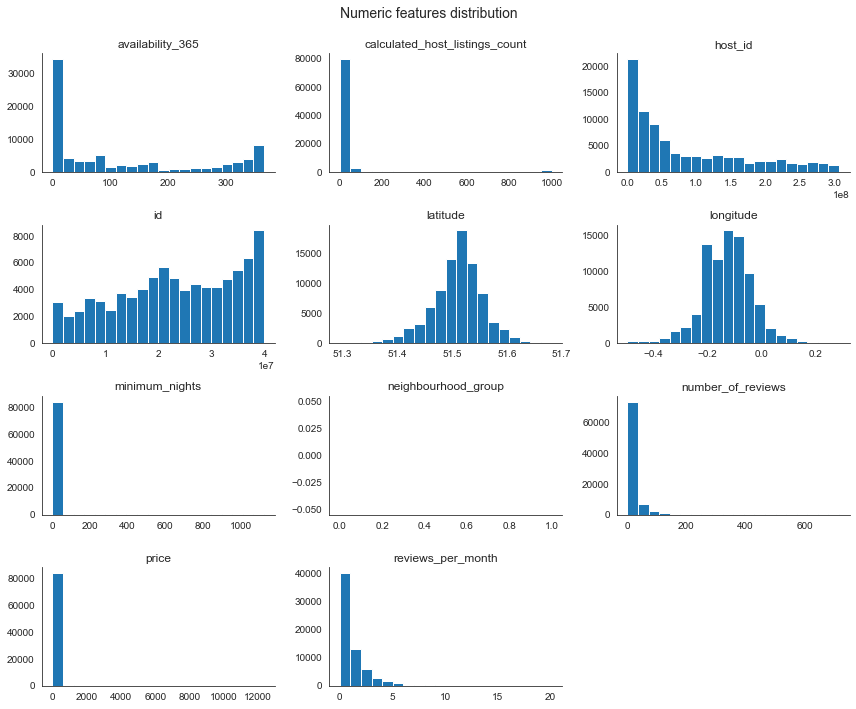

In [26]:
listings_df.hist(figsize=(12, 10), bins=20, grid=False)
sns.despine()
plt.suptitle('Numeric features distribution', fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])

**伦敦的详细房源数据**

数据样本

In [27]:
listings_detail_df.head(1)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,11551,https://www.airbnb.com/rooms/11551,20191105115249,2019-11-06,Arty and Bright London Apartment in Zone 2,Unlike most rental apartments out there my fla...,"Amenities Bedding: 1 Double bed, 1 living room...",Unlike most rental apartments out there my fla...,family,Not even 10 minutes by metro from Victoria Sta...,...,t,f,strict_14_with_grace_period,f,t,2,2,0,0,1.58


存在缺失值的特征

In [28]:
print(listings_detail_df.shape)
listings_detail_df.loc[:, listings_detail_df.isnull().sum() > 0].isnull().sum().sort_values(ascending=False)

(85068, 106)


medium_url                      85068
xl_picture_url                  85068
neighbourhood_group_cleansed    85068
host_acceptance_rate            85068
thumbnail_url                   85068
jurisdiction_names              85066
license                         84889
square_feet                     84671
monthly_price                   80103
weekly_price                    78112
notes                           52269
access                          39320
house_rules                     35807
host_about                      35751
interaction                     35286
transit                         30748
neighborhood_overview           30374
security_deposit                29125
host_response_rate              25900
host_response_time              25900
space                           25850
review_scores_checkin           21723
review_scores_value             21722
review_scores_location          21721
review_scores_accuracy          21675
review_scores_communication     21667
review_score

零方差的特征

In [29]:
listings_detail_df.loc[:, listings_detail_df.nunique() <= 1].nunique().sort_values()

thumbnail_url                   0
medium_url                      0
xl_picture_url                  0
host_acceptance_rate            0
neighbourhood_group_cleansed    0
scrape_id                       1
has_availability                1
jurisdiction_names              1
is_business_travel_ready        1
dtype: int64

不同评论分数的缺失值数量占比情况

In [30]:
listings_detail_df.filter(regex='review_scores').notnull().sum(axis=1).value_counts(normalize=True)

7    0.744310
0    0.254103
4    0.000470
3    0.000400
6    0.000270
1    0.000259
2    0.000141
5    0.000047
dtype: float64

时间特征的汇总信息

In [31]:
listings_detail_df.describe(include='datetime')

,last_scraped,host_since,calendar_last_scraped,first_review,last_review
count,85068,85056,85068,65062,65062
unique,2,3459,2,2802,1818
top,2019-11-06 00:00:00,2015-05-21 00:00:00,2019-11-06 00:00:00,2019-01-01 00:00:00,2019-11-03 00:00:00
freq,59108,1034,59108,205,1688
first,2019-11-05 00:00:00,2008-09-03 00:00:00,2019-11-05 00:00:00,2009-12-21 00:00:00,2011-07-02 00:00:00
last,2019-11-06 00:00:00,2019-11-04 00:00:00,2019-11-06 00:00:00,2019-11-06 00:00:00,2019-11-06 00:00:00


字符特征的汇总信息

In [32]:
listings_detail_df.describe(include='object')

,count,unique,top,freq
listing_url,85068,85068,https://www.airbnb.com/rooms/31444517,1
name,85043,82446,Double room,37
summary,80736,74249,"Featured in The New York Times, The Wall Stree...",214
space,59218,53964,Duchy House is a 19th century building and has...,30
description,82683,78831,Lovely studios situated in an excellent centra...,26
experiences_offered,85068,5,none,83388
neighborhood_overview,54694,44382,Conveniently located in Maida Vale one of Lond...,66
notes,32799,25384,"No smoking, pets or parties!",151
transit,54320,45959,Transport links are excellent with convenient ...,93
access,45748,33418,Guests will have access to the entire property...,1583


国家代码分布

In [33]:
print(listings_detail_df['country_code'].value_counts())
listings_detail_df.query('country_code != "GB"')

GB    85065
FR        2
ES        1
Name: country_code, dtype: int64


,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
41783,23325697,https://www.airbnb.com/rooms/23325697,20191105115249,2019-11-06,Can torres,M7 minutes to Ibiza Town,NaN,M7 minutes to Ibiza Town,none,NaN,...,t,f,flexible,f,f,1,1,0,0,NaN
57006,30320965,https://www.airbnb.com/rooms/30320965,20191105115249,2019-11-05,"Chambre idéal pour couple, 10min à pied de Camden",Chambre lumineuse très bien situé à 7min à pie...,L’appartement est calme et très bien situé pou...,Chambre lumineuse très bien situé à 7min à pie...,none,Vous trouverez une station de métro (Kentish T...,...,f,f,flexible,f,f,1,0,1,0,0.1
61178,32394504,https://www.airbnb.com/rooms/32394504,20191105115249,2019-11-06,"Cosy one bedroom , near station Edgware",NaN,NaN,NaN,none,NaN,...,f,f,flexible,f,f,2,1,1,0,NaN


数值特征分布

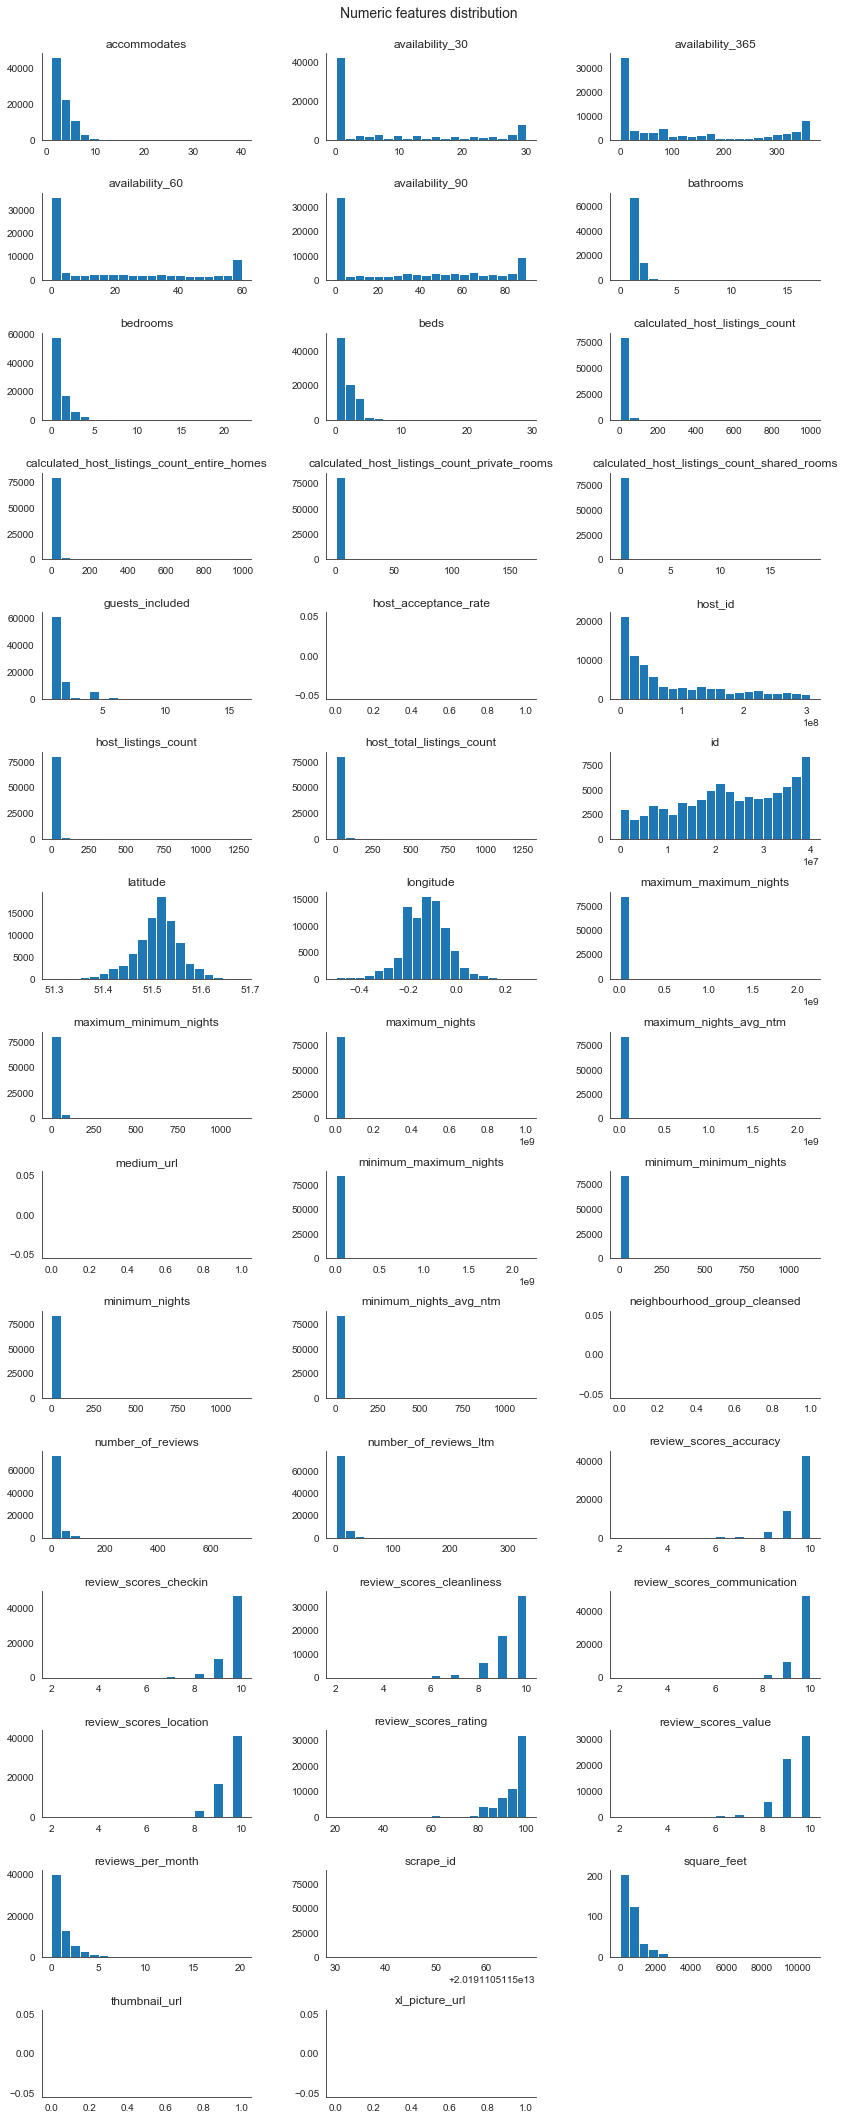

In [34]:
listings_detail_df.hist(figsize=(12, 30), bins=20, grid=False, layout=(15, 3))
sns.despine()
plt.suptitle('Numeric features distribution', fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.97])

**伦敦房源详细的Calendar数据**

数据样本

In [35]:
calendar_df.head(1)

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,11551,2019-11-06,f,$105.00,$105.00,3.0,180.0


有缺失值的特征

In [36]:
print(calendar_df.shape)
calendar_df.loc[:, calendar_df.isnull().sum() > 0].isnull().sum().sort_values(ascending=False)

(31050094, 7)


adjusted_price    918
price             918
maximum_nights     10
minimum_nights     10
dtype: int64

时间特征的汇总信息

In [37]:
calendar_df.describe(include='datetime')

,date
count,31050094
unique,366
top,2020-07-05 00:00:00
freq,85068
first,2019-11-05 00:00:00
last,2020-11-04 00:00:00


字符特征的汇总信息

In [38]:
calendar_df.describe(include='object')

,available,price,adjusted_price
count,31050094,31049176,31049176
unique,2,2684,2696
top,f,$50.00,$50.00
freq,20898260,949237,949577


**评论数据和房源ID的汇总信息**

数据样本

In [39]:
reviews_df.head(1)

,listing_id,date
0,11551,2010-03-21


有缺失值的特征

In [40]:
print(reviews_df.shape)
reviews_df.loc[:, reviews_df.isnull().sum() > 0].isnull().sum().sort_values(ascending=False)

(1486236, 2)


Series([], dtype: float64)

时间特征的汇总信息

In [41]:
reviews_df.describe(include='datetime')

,date
count,1486236
unique,3302
top,2019-07-07 00:00:00
freq,3731
first,2009-12-21 00:00:00
last,2019-11-06 00:00:00


数值特征的分布

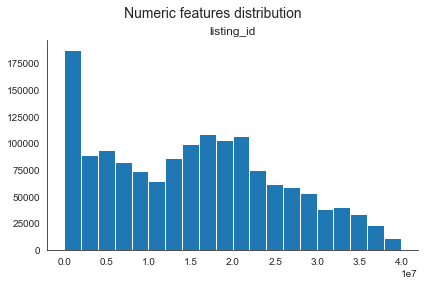

In [42]:
reviews_df.hist(bins=20, grid=False)
sns.despine()
plt.suptitle('Numeric features distribution', fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])

**伦敦房源的详细评论信息**

数据样本

In [43]:
reviews_detail_df.head(1)

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,11551,30672,2010-03-21,93896,Shar-Lyn,"The flat was bright, comfortable and clean and..."


有缺失值的特征

In [44]:
print(reviews_detail_df.shape)
reviews_detail_df.loc[:, reviews_detail_df.isnull().sum() > 0].isnull().sum().sort_values(ascending=False)

(1486236, 6)


comments    622
dtype: int64

时间特征的汇总信息

In [45]:
reviews_detail_df.describe(include='datetime')

,date
count,1486236
unique,3302
top,2019-07-07 00:00:00
freq,3731
first,2009-12-21 00:00:00
last,2019-11-06 00:00:00


字符特征的汇总信息

In [46]:
reviews_detail_df.describe(include='object')

,reviewer_name,comments
count,1486236,1485614
unique,141702,1426862
top,David,The host canceled this reservation 2 days befo...
freq,12654,1646


数值特征分布

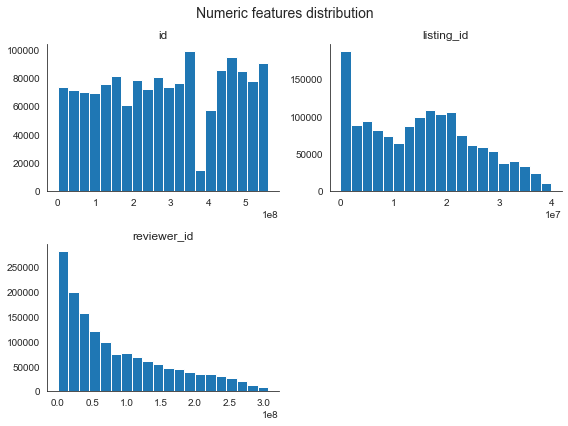

In [47]:
reviews_detail_df.hist(figsize=(8, 6), bins=20, grid=False)
sns.despine()
plt.suptitle('Numeric features distribution', fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])

**地理过滤器的街区列表**

数据样本

In [48]:
neighbourhoods_df.head(1)

,neighbourhood_group,neighbourhood
0,NaN,Barking and Dagenham


有缺失值的特征

In [49]:
print(neighbourhoods_df.shape)
neighbourhoods_df.loc[:, neighbourhoods_df.isnull().sum() > 0].isnull().sum().sort_values(ascending=False)

(33, 2)


neighbourhood_group    33
dtype: int64

字符特征汇总信息

In [50]:
neighbourhoods_df.describe(include='object')

,neighbourhood
count,33
unique,33
top,Croydon
freq,1


**城市街区的GeoJSON文件**

数据样本

In [51]:
gdf.head(1)

,neighbourhood,neighbourhood_group,geometry
0,Kingston upon Thames,None,"MULTIPOLYGON (((-0.33068 51.32901, -0.33059 51..."


有方差的特征

In [52]:
print(gdf.shape)
gdf.loc[:, gdf.isnull().sum() > 0].isnull().sum().sort_values(ascending=False)

(33, 3)


neighbourhood_group    33
dtype: int64

字符特征的汇总信息

In [53]:
gdf.describe(include='object')

,neighbourhood,neighbourhood_group
count,33,0.0
unique,33,0.0
top,Croydon,NaN
freq,1,NaN


**数据探索结果报告** 

Listings data
- 包含2008-09-03 00:00:00至2019-11-04 00:00:00期间注册的房源数据。
- 特征
   - 有很多高倾斜度的数字特征
   - 有很多文字特征，有不同的描述
   - 数据有3个非 gb 国家代码的列表(2-France，1-Spain)和奇怪的位置(根据它们的信息页)
- 缺失值
   - 有一些特征的值全部为空
   - 有一些特征是与同一实体相关的，具有相同的缺失值数量
      - 有超过 25% 的记录的评论分数为空
   - 很多特征都有缺失值 
   
Calendar data 
- 包含2019-11-05 00:00:00至2020-11-04 00:00:00的可用性和价格数据
- 特征
   - 这些数据与 Inside Airbnb 项目的数据描述不一致(http://insideairbnb.com/about.html)
- 缺失值
   - 价格和租期信息的缺失值很少

Reviews data
- 包含从2009-12-21 00:00:00到2019-11-06 00:00:00创建的评论数据
- 特征
   - 数据仅与评论者及其对特定房源的评论有关
- 缺失值
   - 仅有评论特征有一些缺失值

Geo data
- 包含伦敦所有33个居民区的地理信息及其名称

以下信息可用于进一步分析： 
- 多种类型的客人评价分数
- Neighbourhood 属性
- Host 属性
- Listing 属性

为了进一步分析和回答问题，我们将只使用以下数据集：
- Detailed listings data for London
- GeoJSON file of neighbourhoods of the city

## 数据准备

### 选择数据

选择必要的列和行进行进一步分析

In [54]:
review_cols = ['review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin',
               'review_scores_communication', 'review_scores_location', 'review_scores_value']
host_cols = ['host_since', 'host_response_time',
             'host_is_superhost', 'host_has_profile_pic', 'host_identity_verified']

listing_detail_cols = ['id', 'instant_bookable', 'neighbourhood_cleansed', 'room_type'] + review_cols + host_cols 


res_listings_detail_df = listings_detail_df.query('country_code == "GB"')
res_listings_detail_df = res_listings_detail_df[res_listings_detail_df['host_name'].notnull()]
res_listings_detail_df = res_listings_detail_df[res_listings_detail_df.filter(regex='review_scores').notnull().all(axis=1)]
res_listings_detail_df = res_listings_detail_df[listing_detail_cols].rename({'neighbourhood_cleansed': 'neighbourhood'}, axis=1)
res_listings_detail_df.head()

,id,instant_bookable,neighbourhood,room_type,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,host_since,host_response_time,host_is_superhost,host_has_profile_pic,host_identity_verified
0,11551,t,Lambeth,Entire home/apt,9.0,9.0,10.0,10.0,9.0,9.0,2009-10-03,within an hour,t,t,t
2,13913,f,Islington,Private room,10.0,10.0,10.0,10.0,9.0,9.0,2009-11-16,within a few hours,f,t,f
3,38407,t,Tower Hamlets,Entire home/apt,9.0,10.0,10.0,10.0,9.0,9.0,2010-07-12,a few days or more,f,t,f
4,90700,t,Kensington and Chelsea,Entire home/apt,9.0,9.0,10.0,10.0,10.0,9.0,2011-04-07,within a day,f,t,f
5,15400,t,Kensington and Chelsea,Entire home/apt,10.0,10.0,10.0,10.0,10.0,9.0,2009-12-05,NaN,f,t,t


选定数据子集的汇总信息

In [55]:
res_listings_detail_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63313 entries, 0 to 85052
Data columns (total 15 columns):
id                             63313 non-null int64
instant_bookable               63313 non-null object
neighbourhood                  63313 non-null object
room_type                      63313 non-null object
review_scores_accuracy         63313 non-null float64
review_scores_cleanliness      63313 non-null float64
review_scores_checkin          63313 non-null float64
review_scores_communication    63313 non-null float64
review_scores_location         63313 non-null float64
review_scores_value            63313 non-null float64
host_since                     63313 non-null datetime64[ns]
host_response_time             47964 non-null object
host_is_superhost              63313 non-null object
host_has_profile_pic           63313 non-null object
host_identity_verified         63313 non-null object
dtypes: datetime64[ns](1), float64(6), int64(1), object(7)
memory usage: 7.7+ MB


**城市街区的GeoJSON文件**

选择非空的地理数据进行进一步分析

In [56]:
geo_cols = ['neighbourhood', 'geometry']
res_gdf = gdf.loc[:, geo_cols]
res_gdf.head()

,neighbourhood,geometry
0,Kingston upon Thames,"MULTIPOLYGON (((-0.33068 51.32901, -0.33059 51..."
1,Croydon,"MULTIPOLYGON (((-0.06402 51.31864, -0.06407 51..."
2,Bromley,"MULTIPOLYGON (((0.01213 51.29960, 0.01196 51.2..."
3,Hounslow,"MULTIPOLYGON (((-0.24456 51.48870, -0.24468 51..."
4,Ealing,"MULTIPOLYGON (((-0.41183 51.53408, -0.41188 51..."


**列入/排除的理由**

Guest review scores
- 列入的理由
   - 分析的主要特征

- 特征
   - review_scores_accuracy 
      - 房源页对空间的表现有多准确？
   - review_scores_cleanliness
       - 客人是否觉得房间干净整洁？
   - review_scores_checkin
       - 办理手续的顺利程度如何？
   - review_scores_communication
       - 入住前和入住期间的沟通情况如何？
   - review_scores_location
       - 客人对小区的感觉如何？
   - review_scores_value
       - 客人是否觉得该房源提供的价格物有所值？
       
Neighbourhood properties
- 列入的理由 
    - 计算和比较不同街区价值的必要信息
- 特征
    - neighbourhood
        - Neighbourhood name
        
Host properties
- 列入的理由
    - 我们可以假设房东的属性（与状态、安全、响应度等相关）与客人的评论分数有关系。
- 特征
    - host_since
        - 房主的登记日期
    - host_response_time
        - 房主的平均反应时间
    - host_is_superhost
        - 房主是否为超级房主
    - host_has_profile_pic
        - 房主是否有照片在个人资料中
    - host_identity_verified
        - 房主的身份是否已经核实
        
Listing properties
- 列入的理由
    - 不同的客人可以在不同的房型中舒适地生活或办理预订手续。
- 特征
    - listing_id 
        - 列出唯一的标识符
    - room_type
        - 房屋类型
    - instant_bookable
        - 预订时是否需要主人的额外批准 

- 删除了3个带有非英国国家代码的清单
- 12个与房主相关的缺失最多的特征被删除
- 所有清单的评论分数为空的都会被删除

Geo data
- 列入的理由
    - 绘制和合并地理数据到列表数据所需的必要信息。
- 特征
    - neigbourhood
        - Neighbourhood name
    - geometry
        - 邻近地区的地理数据（多边形）
        


### 数据清洗

伦敦房源的汇总信息和指标

不清洗

**伦敦的详细房源数据**

将列转换为所需类型，清理数据，并计算非聚合特征

In [57]:
binary_cols = ['instant_bookable', 'host_is_superhost', 'host_has_profile_pic', 'host_identity_verified']
binary_map = {'f': False, 't': True}
res_listings_detail_df[binary_cols] = res_listings_detail_df[binary_cols].apply(lambda x: x.map(binary_map)).astype(bool)

cat_type = pd.api.types.CategoricalDtype(['not specified', 'within an hour', 'within a few hours', 'within a day', 'a few days or more'])
res_listings_detail_df['host_response_time'] = res_listings_detail_df['host_response_time'].fillna('not specified').astype(cat_type)

清洗后的汇总信息

In [58]:
res_listings_detail_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63313 entries, 0 to 85052
Data columns (total 15 columns):
id                             63313 non-null int64
instant_bookable               63313 non-null bool
neighbourhood                  63313 non-null object
room_type                      63313 non-null object
review_scores_accuracy         63313 non-null float64
review_scores_cleanliness      63313 non-null float64
review_scores_checkin          63313 non-null float64
review_scores_communication    63313 non-null float64
review_scores_location         63313 non-null float64
review_scores_value            63313 non-null float64
host_since                     63313 non-null datetime64[ns]
host_response_time             63313 non-null category
host_is_superhost              63313 non-null bool
host_has_profile_pic           63313 non-null bool
host_identity_verified         63313 non-null bool
dtypes: bool(4), category(1), datetime64[ns](1), float64(6), int64(1), object(2)
memory u

**数据清洗报告**  

伦敦房源的汇总信息和指标
- 不清洗

伦敦的详细房源数据
- Binary columns 
    - instant_bookable, host_is_superhost, host_has_profile_pic, host_identity_verified
    - 将二进制列转换为bool类型
- host_response_rate
    - 清洗
        - 移除 "%" 标志
        - 转换为float类型
- host_response_time
     - 转换为有序分类类型
     - 所有的空值都用唯一值（"not specified"）填充
        - 假设缺乏信息对分析客人的评论关系是有用的 

### 构建数据 

根据地理数据计算非聚合特征。

In [59]:
res_gdf['area_sq_km'] = (res_gdf['geometry'].to_crs({'init': 'epsg:3395'})
                                    .map(lambda p: p.area / 10**6))

res_listings_detail_df['age'] = (pd.Timestamp('now') - pd.to_datetime(res_listings_detail_df['host_since'])).dt.days.div(365.25).round(2)

F:\Python\Anaconda\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


**衍生属性**

- area_sq_km（面积_平方公里）
   - 居民区面积（平方公里）
- 年龄
   - 房东在Airbnb网站上注册多久了？

### 整合数据 

合并数据并计算聚合特征

In [60]:
geo_listings_df = res_gdf.merge(res_listings_detail_df, how='inner', on='neighbourhood')

geo_listings_df['listings_count'] = geo_listings_df.groupby('neighbourhood')['id'].transform('count')
geo_listings_df['listings_density'] = geo_listings_df.groupby('neighbourhood')['area_sq_km'].transform(lambda x: len(x) / x)

geo_listings_df['mean_review_scores_accuracy'] = geo_listings_df.groupby('neighbourhood')['review_scores_accuracy'].transform('mean')
geo_listings_df['mean_review_scores_cleanliness'] = geo_listings_df.groupby('neighbourhood')['review_scores_cleanliness'].transform('mean')
geo_listings_df['mean_review_scores_checkin'] = geo_listings_df.groupby('neighbourhood')['review_scores_checkin'].transform('mean')
geo_listings_df['mean_review_scores_communication'] = geo_listings_df.groupby('neighbourhood')['review_scores_communication'].transform('mean')
geo_listings_df['mean_review_scores_location'] = geo_listings_df.groupby('neighbourhood')['review_scores_location'].transform('mean')
geo_listings_df['mean_review_scores_value'] = geo_listings_df.groupby('neighbourhood')['review_scores_value'].transform('mean')

geo_listings_df['mean_review_scores_all'] = geo_listings_df.filter(like='mean_review_scores').mean(axis=1)

数据整合后的汇总信息

In [61]:
geo_listings_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 63313 entries, 0 to 63312
Data columns (total 27 columns):
neighbourhood                       63313 non-null object
geometry                            63313 non-null geometry
area_sq_km                          63313 non-null float64
id                                  63313 non-null int64
instant_bookable                    63313 non-null bool
room_type                           63313 non-null object
review_scores_accuracy              63313 non-null float64
review_scores_cleanliness           63313 non-null float64
review_scores_checkin               63313 non-null float64
review_scores_communication         63313 non-null float64
review_scores_location              63313 non-null float64
review_scores_value                 63313 non-null float64
host_since                          63313 non-null datetime64[ns]
host_response_time                  63313 non-null category
host_is_superhost                   63313 non-null bool

**合并数据**
- 合并
    - 类型
        - Inner join
    - Merge key
        - Neighborhood name
- 数据集 
    - Listings detailed info
    - Neighbourhoods geo data
- 汇总 (by neighborhood)
    - listings_count
        - 房源数量
    - listings_density
        - 房源密度(每平方公里)
    - mean_review_scores_*
        - 评论的平均分数(分总体和邻里)

## 理解数据

### 根据客人的评价分数，租房时选择哪个小区比较好？

- 根据特定类型的评论分数，不同的社区可能比其他社区更具吸引力
- 这些信息可能会被用来作为指标，说明某个街区是被低估了还是被高估了

In [62]:
review_cols = ['mean_review_scores_accuracy', 'mean_review_scores_cleanliness', 'mean_review_scores_checkin',
               'mean_review_scores_communication', 'mean_review_scores_location', 'mean_review_scores_value']
review_titles = ['Accuracy', 'Cleanliness', 'Check-in',
                 'Communication', 'Location', 'Value']
review_map = {col: title for col, title in zip(review_cols, review_titles)}

result_df = geo_listings_df[['geometry', 'neighbourhood', 'mean_review_scores_all'] + review_cols].drop_duplicates()

def gen_map_chart(df, review_col, review_title):
    '''Generate choropleth map
    
    Generate choropleth map based on scores of specific review types
    
    :param df: DataFrame with necessary geo data and review scores for different neighbourhood
    :type df: DataFrame
    :param review_col: name of review scores type
    :type review_col: str
    :param review_title: title of review scores type
    :type review_title: str
    :return: Altair Chart for displaying 
    :rtype: Chart
    '''
    chart = alt.Chart(
        df,
        title=review_title
    ).mark_geoshape().encode(
        color=f'{review_col}:Q',
        tooltip=['neighbourhood:N', f'{review_col}:Q']
    ).properties(
        width=250, 
        height=250
    )
    
    return chart

charts = []

for review_col, review_title in zip(review_cols, review_titles):
    charts.append(gen_map_chart(result_df, review_col, review_title))

overall_map_chart = gen_map_chart(result_df, 'mean_review_scores_all', 'Overall')

((alt.vconcat(alt.concat(*charts, columns=3), overall_map_chart, 
              title='Average review scores by neighbourhood', 
              center=True)
     .configure_view(strokeWidth=0)
     .configure_title(fontSize=18)
     .configure_legend(title=None, orient='top',  labelFontSize=12)))

alt.VConcatChart(...)

**结论**
- 按位置划分，伦敦中心的街区对客人的吸引力更大，尤其是泰晤士河北侧的街区（按**位置**划分的平均评论得分）。
    - Kensington and Chelsea (~9.76)
    - Westminster (~9.73)
    - Camden (~9.73)
- 中心区域在其他方面对客人来说就不是很好了。  
  看来中部地区要么是价格太贵，要么就是中部的房主不像其他房主那样注重不同方面的问题。
- 不同类型的点评之间可能会有偏差，所以有几种点评类型的平均分（如Check-in和Communication）要比其他类型（如Cleanliness）高很多
- 一般来说，最好的地区（对应客人总体平均评论得分）位于伦敦的西南部（**总体**平均评论得分）。
    - Kingston Upon Thames (~9.70)
    - Richmond Upon Thames (~9.69)
- 有一个地区是大多数评论类型和总体上最差的地区（**总体**平均评论得分）。
    - Bexley (~9.2)

### 不同类型的客人评价分数之间有什么关系吗？

- 不同的评论类型可以与其他评论类型相关，而另一个评论可以是独立的
- 这些信息可以用于根据另一个客人评论类型的已知值进行分数预测

In [63]:
result_df = (geo_listings_df[review_cols].rename(review_map, axis=1)
                                         .corr()
                                         .reset_index()
                                         .melt(id_vars='index')
                                         .rename({'value': 'correlation'}, axis=1))

base = alt.Chart(
    result_df,
    title='Average Review Scores Relationship'
).properties(
    width=600, 
    height=600
)

heatmap = base.mark_rect().encode(
    x=alt.X('index:N', title=None),
    y=alt.Y('variable:N', title=None),
    color='correlation:Q'
)

text = base.mark_text(baseline='middle').encode(
    x=alt.X('index:N', title=None),
    y=alt.Y('variable:N', title=None),
    text=alt.Text('correlation:Q', format='.2f'),
    color=alt.condition(
        alt.datum.correlation < 0,
        alt.value('black'),
        alt.value('white')
    )
)

(heatmap + text).configure_axis(
    labelAngle=0,
    labelFontSize=14
).configure_legend(
    orient='top',
    titleFontSize=14,    
).configure_title(
    fontSize=18,
    offset=15,
    anchor='start',
    frame='group'
)

alt.LayerChart(...)

**结论**
- 除了位置评论得分外，各个评论得分之间有很强的正向关系。
    - 如果客人在准确度、入住、清洁度、沟通或价值方面给出了高分，那么其他4项评价得分也很有可能是高分。
- 位置点评得分与其他得分之间存在负相关关系。
    - 如果客人给房源的位置打高分，那么房源的其他方面就很可能没有那么大的吸引力。
- 看来，清洁度评测得分与其他评测得分的独立性最强。

### 房东/房源属性与客人评价分数的关系如何？

- 房源及其业主（房东）的不同方面都会对客人的评论分数产生影响
- 这些信息可用于确定可能的房主和房源特征，以便改进

In [64]:
def gen_parallel_chart(df, class_col, class_title):
    '''Generate parallel coordinates chart
    
    Generate parallel coordinates chart based on specific class column by different review score types
    
    :param df: DataFrame with necessary data for class column calculation
    :type df: DataFrame
    :param class_col: name of class column 
    :type class_col: str
    :param class_title: title of review scores type
    :type class_title: str
    :return: Altair Chart for displaying 
    :rtype: Chart
    '''
    result_df = (df.groupby(class_col)[review_cols]
                   .mean()
                   .reset_index()
                   .melt(id_vars=class_col))
    result_df['variable'] = result_df['variable'].map(review_map)

    chart = alt.Chart(
        result_df,
        title = f'{class_title}'
    ).mark_line().encode(
        x=alt.X('variable:N',
                title=None),
        y=alt.Y('value:Q',
                scale=alt.Scale(zero=False),
                axis=None),
        color=f'{class_col}:N'
    ).properties(
        width=750, 
        height=300
    )
    
    return chart

class_cols = ['room_type', 'instant_bookable', 'host_is_superhost']
class_titles = ['Room Type', 'Listing is Instant Bookable', 'Host is Superhost']

charts = []

for class_col, class_title in zip(class_cols, class_titles):
    charts.append(gen_parallel_chart(geo_listings_df, class_col, class_title))
    
(alt.concat(*charts, columns=1, title='Average Review Scores by Host/Listing Properties')
    .configure_view(strokeWidth=0)
    .configure_legend(
        title=None, 
        orient='top', 
        columns=0,
        labelFontSize=14)
    .configure_axis(
        labelAngle=0,
        grid=False,
        labelFontSize=14)
    .configure_title(
        anchor='start',
        fontSize=18,
        offset=15)
    .resolve_scale(color='independent')
)

alt.ConcatChart(...)

**结论**

- 客人对私房和合租房的评价一直高于其他类型的房间（除了位置）
- 对于位置点评得分，最好的房型是整栋住宅/公寓和酒店客房
- 如果预订时不需要房东的额外批准（即时可预订房源），那么客人的评价就会一直比较好（除了位置）
- 如果房东是超级房东，那么客人的评价就会一直比较好（除了位置）

## 评估

### 评估结果 

**根据业务成功标准评估数据挖掘结果**

- 不同的点评分值之间以及与不同的房东/房源/小区属性之间有密切的关系
- 这些关系可以用来进一步分析如何提高房东的声誉和Airbnb的总体声誉

### 回顾整个过程

**回顾过程**

- 从Airbnb网站上收集的数据被用来探讨客人的评论与房东和房源不同方面的关系。
- 只选取所有非空评分类型的Airbnb房源子集进行分析。
- 我们只选择了一小部分特征进行分析，假设哪些特征与客人的评论分数关系最密切。
- 没有根据供应情况/价格对房源进行过滤。
- 仅使用描述性统计数字进行分析

### 确定下一步

**可能的行动方向**
- 寻找已经找到的关系的可能用途，以激励房东改善客人的体验。
- 继续了解数据
    - 使用房源数据集中的另一个特征
        - Different host/listing properties
    - 使用数据集中的另一个文件进行进一步的探索和分析。
        - Reviews
            - Review texts
        - Calendar data
            - Availabitily
            - Price